In [1]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from PIL import Image
from skimage.segmentation import slic, mark_boundaries
from skimage.filters import threshold_otsu
from scipy.ndimage import gaussian_filter
from datetime import datetime
from skimage.segmentation import slic


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Part 1: Refining the epithelium extraction method
## Note: mine and alex's code are the same since we worked on it together, we ran the final images on his computer since his computer is faster than mine

### Adjustments
#### classification relies on hardcoded RGB value ranges to classify regions as epithelium, stroma, or background 
#### In the original code, regions within the epithelium are color-coded based on purple concentration
#### This code preserves the original image colors for the epithelium

def generate_epithelium_mask(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (45, 45), 0)
    _, thresholded_mask = cv2.threshold(blurred_image, 200, 255, cv2.THRESH_BINARY_INV)
    kernel_huge = np.ones((45, 45), np.uint8)
    cleaned_mask = cv2.morphologyEx(thresholded_mask, cv2.MORPH_CLOSE, kernel_huge)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel_huge)

    kernel_medium = np.ones((25, 25), np.uint8)
    generalized_cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel_medium)
    generalized_cleaned_mask = cv2.morphologyEx(generalized_cleaned_mask, cv2.MORPH_OPEN, kernel_medium)

    # Find contours for the generalized mask
    contours, _ = cv2.findContours(generalized_cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on a separate mask
    contour_mask = np.zeros_like(generalized_cleaned_mask)
    cv2.drawContours(contour_mask, contours, -1, 255, thickness=cv2.FILLED)
    
    return contour_mask, contours, image

def classify_superpixels_with_thresholds(image, contour_mask, num_segments=750):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    segments = slic(image_rgb, n_segments=num_segments, compactness=10, start_label=1)
    segmented_image = np.zeros_like(image_rgb)
    
    # Hardcoded RGB thresholds for epithelium, stroma, and background
    epithelium_lower = np.array([120, 0, 0])
    epithelium_upper = np.array([180, 100, 100])
    stroma_lower = np.array([200, 180, 150])
    stroma_upper = np.array([255, 220, 200])

    for segment_value in np.unique(segments):
        segment_mask = (segments == segment_value)
        
        # Separate parts inside and outside the contour using the contour mask
        inside_mask = np.logical_and(segment_mask, contour_mask > 0)
        
        # Process inside region
        if np.sum(inside_mask) > 0:
            inside_segment = np.zeros_like(image_rgb)
            inside_segment[inside_mask] = image_rgb[inside_mask]

            # Check RGB values and classify as epithelium, stroma, or background
            if cv2.inRange(inside_segment, epithelium_lower, epithelium_upper).any():
                segmented_image[inside_mask] = [255, 0, 0]  # Color for epithelium
            elif cv2.inRange(inside_segment, stroma_lower, stroma_upper).any():
                segmented_image[inside_mask] = [0, 255, 0]  # Color for stroma
            else:
                segmented_image[inside_mask] = [0, 0, 0]  # Background

    plt.figure(figsize=(10, 10))
    plt.imshow(segmented_image)
    plt.title("Segmented Epithelium, Stroma, and Background")
    plt.axis('off')
    plt.show()
    
    return segmented_image

# Combining both steps
def combined_threshold_segmentation(image_path):
    contour_mask, contours, original_image = generate_epithelium_mask(image_path)
    segmented_image = classify_superpixels_with_thresholds(original_image, contour_mask)
    cv2.imwrite('Segmented_Epithelium_Stroma_Background.tif', cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR))

# Run on an example image
combined_threshold_segmentation("image2.tif")


In [2]:
def generate_epithelium_mask(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (45, 45), 0)
    _, thresholded_mask = cv2.threshold(blurred_image, 200, 255, cv2.THRESH_BINARY_INV)
    kernel_huge = np.ones((45, 45), np.uint8)
    cleaned_mask = cv2.morphologyEx(thresholded_mask, cv2.MORPH_CLOSE, kernel_huge)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel_huge)

    kernel_medium = np.ones((25, 25), np.uint8)
    generalized_cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel_medium)
    generalized_cleaned_mask = cv2.morphologyEx(generalized_cleaned_mask, cv2.MORPH_OPEN, kernel_medium)

    # Find contours for the generalized mask
    contours, _ = cv2.findContours(generalized_cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on a separate mask
    contour_mask = np.zeros_like(generalized_cleaned_mask)
    cv2.drawContours(contour_mask, contours, -1, 255, thickness=cv2.FILLED)
    
    return contour_mask, contours, image

def classify_superpixels_with_thresholds(image, contour_mask, num_segments=750):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    segments = slic(image_rgb, n_segments=num_segments, compactness=10, start_label=1)
    segmented_image = np.zeros_like(image_rgb)
    
    #USING HISTOGRAM IDEA
    epithelium_lower = np.array([120, 0, 0])
    epithelium_upper = np.array([180, 100, 100])
    stroma_lower = np.array([200, 180, 150])
    stroma_upper = np.array([255, 220, 200])

    for segment_value in np.unique(segments):
        segment_mask = (segments == segment_value)
        
        # Separate parts inside and outside the contour using the contour mask
        inside_mask = np.logical_and(segment_mask, contour_mask > 0)
        
        # Process inside region
        if np.sum(inside_mask) > 0:
            inside_segment = np.zeros_like(image_rgb)
            inside_segment[inside_mask] = image_rgb[inside_mask]

            # Check RGB values and classify as epithelium, stroma, or background
            if cv2.inRange(inside_segment, epithelium_lower, epithelium_upper).any():
                # Retain the original image colors for epithelium
                segmented_image[inside_mask] = image_rgb[inside_mask]
            elif cv2.inRange(inside_segment, stroma_lower, stroma_upper).any():
                segmented_image[inside_mask] = [255, 255, 255]  # White for stroma
            else:
                segmented_image[inside_mask] = [0, 0, 0]  # Black for background

    plt.figure(figsize=(10, 10))
    plt.imshow(segmented_image)
    plt.title("Segmented Image with Original Epithelium Color")
    plt.axis('off')
    plt.show()
    
    return segmented_image

# Combining both steps
def combined_threshold_segmentation(image_path):
    contour_mask, contours, original_image = generate_epithelium_mask(image_path)
    segmented_image = classify_superpixels_with_thresholds(original_image, contour_mask)
    cv2.imwrite('Segmented_Epithelium_Stroma_Background_with_Original_Epithelium.tif', cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR))


In [3]:
#combined_threshold_segmentation("image2.tif")

## Part 2: Sampling using **<font color ='purple'>local width</font>**

In [4]:
def load_image_with_presegmentation(image_path):
    image = cv2.imread(image_path)
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, grayscale_image

In [5]:
# Check if a new sample overlaps with any existing sample
def is_overlapping(new_coords, existing_coords, min_distance=50):
    x1_new, y1_new, x2_new, y2_new = new_coords
    for (x1_old, y1_old, x2_old, y2_old) in existing_coords:
        
        # Calculate the distance between centers of rectangles
        center_x_old, center_y_old = (x1_old + x2_old) // 2, (y1_old + y2_old) // 2
        center_x_new, center_y_new = (x1_new + x2_new) // 2, (y1_new + y2_new) // 2
        distance = np.sqrt((center_x_new - center_x_old)**2 + (center_y_new - center_y_old)**2)
        
        if distance < min_distance:
            return True
        
    return False

In [6]:
# Alyssa's Sampling Method

def sample_across_epithelium(image, grayscale_image, num_samples=5, min_size=(40, 40), max_size=(1500, 1500)):
    samples = []
    sample_coords = []
    height, width = image.shape[:2]

    edges = cv2.Canny(grayscale_image, 100, 200)  # Edge detection to find epithelium boundaries
    
    for _ in range(num_samples):
        
        for attempt in range(500):
            
            # Randomly select a center point for the sample box in the black area (background)
            center_x = random.randint(min_size[0] // 2, width - min_size[0] // 2)
            center_y = random.randint(min_size[1] // 2, height - min_size[1] // 2)

            # Define the sample box
            sample_width = random.randint(min_size[0], max_size[0])
            sample_height = random.randint(min_size[1], max_size[1])

            x1 = max(0, center_x - sample_width // 2)
            y1 = max(0, center_y - sample_height // 2)
            x2 = min(width, center_x + sample_width // 2)
            y2 = min(height, center_y + sample_height // 2)
            
            # Skip sample if it overlaps with an existing sample
            if is_overlapping((x1, y1, x2, y2), sample_coords):
                continue  
            
            # Crop the sample and check edge detection within the box
            sample_rgb = image[y1:y2, x1:x2]
            sample_edges = edges[y1:y2, x1:x2]
            
            # Ensure the sample contains both black and white regions
            white_pixels = np.sum(np.all(sample_rgb == [255, 255, 255], axis=-1))  # White pixels (stroma)
            black_pixels = np.sum(np.all(sample_rgb == [0, 0, 0], axis=-1))  # Black pixels (background)

            # Enforce a roughly equal proportion of black and white pixels
            # Skip this sample if the balance is off
            if abs(white_pixels - black_pixels) > (0.2 * (white_pixels + black_pixels)):
                continue

            # Convert the sample to HSV for purple detection
            sample_hsv = cv2.cvtColor(sample_rgb, cv2.COLOR_RGB2HSV)
            
            # Ensure that purple pixels make up more than 20% of the sample
            total_pixels = sample_rgb.shape[0] * sample_rgb.shape[1]
            purple_mask = cv2.inRange(sample_hsv, np.array([125, 40, 40]), np.array([155, 255, 255]))
            purple_pixels = np.sum(purple_mask > 0)

            if (purple_pixels / total_pixels) >= 0.2 and np.sum(sample_edges) > 100 and (white_pixels / total_pixels) > 0.01 and (black_pixels / total_pixels) > 0.01:
                samples.append(sample_rgb)
                sample_coords.append((x1, y1, x2, y2))
                break  
    
    return samples, sample_coords

In [7]:
def save_samples(samples):
    
    base_name = "Samples"
    folder_count = 1
    while os.path.exists(f"{base_name}_{folder_count}"):
        folder_count += 1
    folder_name = f"{base_name}_{folder_count}"
    os.makedirs(folder_name)

    for i, sample in enumerate(samples):
        file_path = os.path.join(folder_name, f"sample_{i+1}.tif")
        cv2.imwrite(file_path, sample)
    
    print(f"Saved {len(samples)} samples to the '{folder_name}' folder.")

In [8]:
def display_image_with_boxes(image_path, num_samples=10):

    image, grayscale_image = load_image_with_presegmentation(image_path)
    samples, sample_coords = sample_across_epithelium(image, grayscale_image, num_samples=num_samples)

    # Draw red boxes on the original image
    image_with_boxes = image.copy()
    for (x1, y1, x2, y2) in sample_coords:
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Red boxes
        
    # Saving the samples to a folder on my computer
    save_samples(samples)

    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))  # Show the image in RGB
    cv2.imwrite("Image_with_Samples.tif", cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title("Original Image with Sampling Boxes")
    plt.axis('off')
    plt.show()

In [9]:
# EXAMPLE: Run the function to display the image with boxes
#display_image_with_boxes('segmented_image_with_contour_cut.tif')

## Part 3: Putting everything together

In [12]:
def go(image_path):

    combined_threshold_segmentation(image_path)
    display_image_with_boxes('Segmented_Epithelium_Stroma_Background_with_Original_Epithelium.tif')
    
    return

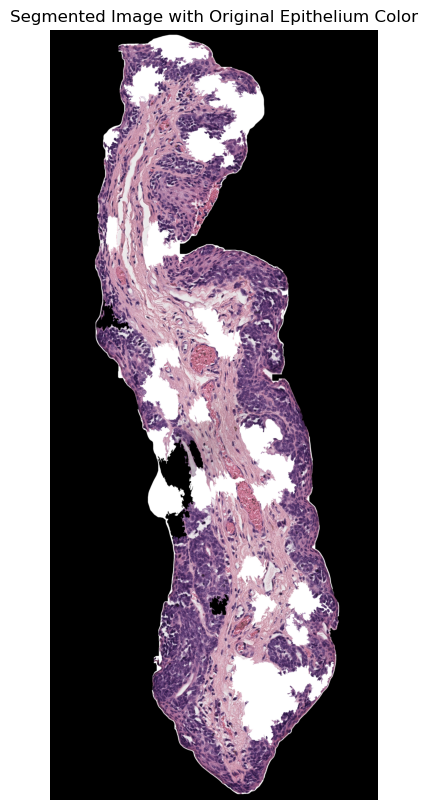

Saved 10 samples to the 'Samples_17' folder.


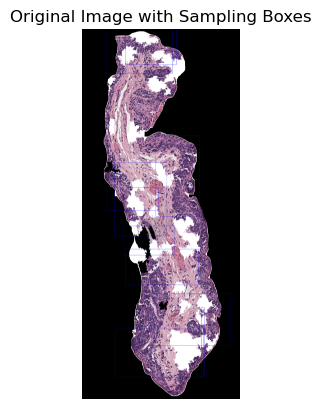

In [13]:
go('image2.tif')

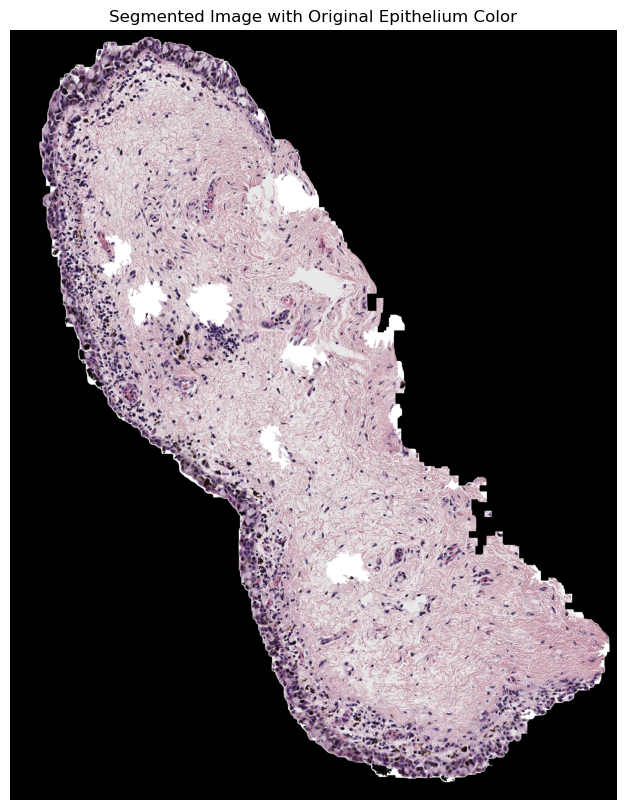

KeyboardInterrupt: 

In [14]:
go('HighQualitySample.tif')

In [ ]:
go('HighQualitySample2.tif')

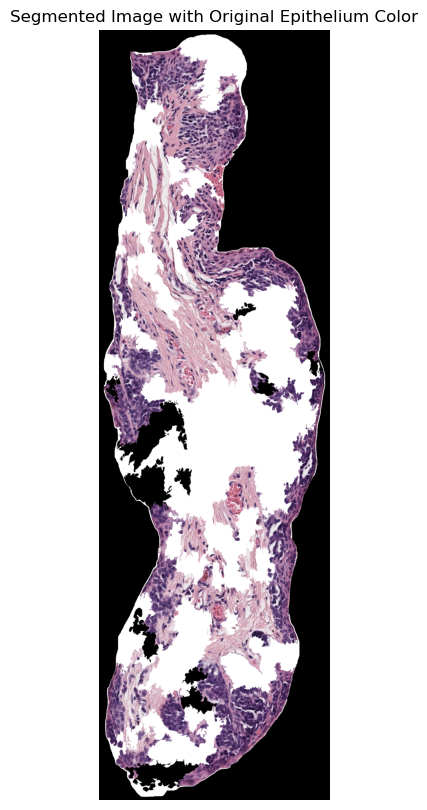

Saved 10 samples to the 'Samples_18' folder.


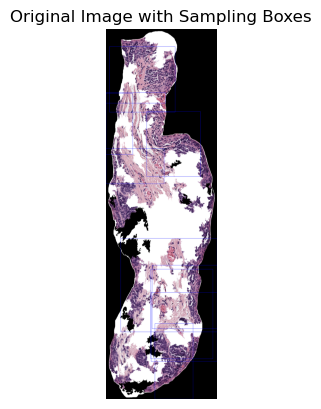

In [15]:
go('h2114153  h&e_ROI_1.tif')

In [16]:
go('h2114180 h&e.tif - Series 0 (1, x=12093, y=151150, w=4950, h=5345).tif')


[ WARN:0@304.823] global loadsave.cpp:241 findDecoder imread_('h2114180 h&e.tif - Series 0 (1, x=12093, y=151150, w=4950, h=5345).tif'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /private/var/folders/x5/bffgyw155ll40t7fzd01yz440000gn/T/pip-install-4znpk30k/opencv-python_2e65eec6c770431284876eb0ac22d6b3/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
